# Projet 6 - Analyse des ventes d'une librairie avec Python

In [1]:
#Importation de la librairie Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.mlab as mlab
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import ks_2samp

In [2]:
#Importation du fichier 'Clients'
clients = pd.read_csv('customers.csv', sep=';')

#Importation du fichier de la table produit de notre plateforme de vente en ligne
produits = pd.read_csv('products.csv', sep=';')

#Importation du fichier qui liste les product_id de l’ERP avec leur référence côté Web
transactions = pd.read_csv('transactions.csv', sep=';')

### Exploration du fichier clients

In [3]:
print('clients = ', clients.shape)
clients.head()

clients =  (8621, 3)


,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [4]:
#Verifiez les types
clients.dtypes

client_id    object
sex          object
birth         int64
dtype: object

In [5]:
#Vérifier si le fichier contient des valeurs manquantes.
print(clients.isnull().sum())

client_id    0
sex          0
birth        0
dtype: int64


In [6]:
#Chercher de doublons pour client_id
print(clients.loc[clients['client_id'].duplicated(keep=False),:])

Empty DataFrame
Columns: [client_id, sex, birth]
Index: []


In [7]:
#Rechercher des valeurs aberrantes
clients.describe()

,birth
count,8621.000000
mean,1978.275606
std,16.917958
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [8]:
#Déterminer si client_id peut être utilisé comme clé primaire
print("Valeurs unique pour client_id = ", clients['client_id'].nunique())
print("Forme du fichier = ", clients.shape)

Valeurs unique pour client_id =  8621
Forme du fichier =  (8621, 3)


### Exploration du fichier produits

In [9]:
print('produits =', produits.shape)
produits.head()

produits = (3286, 3)


,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [10]:
#Verifier les types
produits.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

In [11]:
#Vérifier si le fichier contient des valeurs manquantes.
print(produits.isnull().sum())

id_prod    0
price      0
categ      0
dtype: int64


In [12]:
#Chercher de doublons pour id_prod
print(produits.loc[produits['id_prod'].duplicated(keep=False),:])

Empty DataFrame
Columns: [id_prod, price, categ]
Index: []


In [13]:
#Chercher des outliers
produits.describe()

,price,categ
count,3286.000000,3286.000000
mean,21.863597,0.370359
std,29.849786,0.615446
min,0.620000,0.000000
25%,6.990000,0.000000
50%,13.075000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [14]:
#Déterminer si id_prod peut être utilisé comme clé primaire
print("Valeurs unique pour id_prod = ", produits['id_prod'].nunique())
print("Forme du fichier = ", produits.shape)

Valeurs unique pour id_prod =  3286
Forme du fichier =  (3286, 3)


### Exploration du fichier transactions

In [15]:
print('Transactions =', transactions.shape)
transactions.head()

Transactions = (687534, 4)


,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033


In [16]:
#Verifier les types
transactions.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

Il existe plusieurs lignes pour les transactions où la colonne de date contient des heures de plus de 24 heures (par exemple 2021-10-02 24:04:58.422464 présent à la position 198325). J'ai décidé de changer uniquement la date (10 premiers caractères) afin de pouvoir changer le type de données en datetime.

In [17]:
#Extraire la date de la colonne de date
transactions['dateextract'] = transactions['date'].str[:10]
transactions.head()

,id_prod,date,session_id,client_id,dateextract
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,2021-03-01
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664,2021-03-01
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580,2021-03-01
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912,2021-03-01
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033,2021-03-01


In [18]:
#Supprimer la colonne de date et changer le type de colonne dateextract en datetime
transactions = transactions.drop(columns='date')
transactions['dateextract'] = pd.to_datetime(transactions['dateextract'])
transactions.dtypes

id_prod                object
session_id             object
client_id              object
dateextract    datetime64[ns]
dtype: object

In [19]:
#Vérifier si le fichier contient des valeurs manquantes.
print(transactions.isnull().sum())

id_prod        0
session_id     0
client_id      0
dateextract    0
dtype: int64


# PARTIE 1 – Analyse des différents indicateurs de ventes



### Chiffre d’affaires

In [20]:
# Trouver le chiffre d'affaires total
ca = pd.merge(transactions, produits, on='id_prod', how='left')
ca_total = round(ca['price'].sum(), 2)
print('CA total =', ca_total)
print('---')

# Trouver le chiffre d'affaires pour chaque année
print("Chiffre d'affaires pour chaque année :")
ca['year'] = ca['dateextract'].dt.to_period('Y')
ca.groupby('year')['price'].sum().reset_index().rename(columns={'price':'ca'})

CA total = 12027663.1
---
Chiffre d'affaires pour chaque année :


,year,ca
0,2021,4944760.98
1,2022,6108681.81
2,2023,974220.31


####  L’évolution dans le temps et une décomposition en moyenne mobile 

In [21]:
#Créer une clé de regroupement qui combine l’année et le mois. Converti en chaîne, car plot n'autorise pas les types datetime ou période.
ca['month_year'] = ca['dateextract'].dt.to_period('M')
ca['month_year'] = ca['month_year'].astype(str)

#Créer une dataframe avec les chiffre d'affaires pour chaque mois
ca_par_mois = ca.groupby(['month_year'])['price'].sum().reset_index()

ca_par_mois['moving_average_3'] = ca_par_mois['price'].rolling(window=3).mean()
ca_par_mois['moving_average_2'] = ca_par_mois['price'].rolling(window=2).mean()

ca_par_mois

,month_year,price,moving_average_3,moving_average_2
0,2021-03,482440.61,NaN,NaN
1,2021-04,476109.30,NaN,479274.955
2,2021-05,492943.47,483831.126667,484526.385
3,2021-06,484088.56,484380.443333,488516.015
4,2021-07,482835.40,486622.476667,483461.980
5,2021-08,482284.79,483069.583333,482560.095
6,2021-09,507240.68,490786.956667,494762.735
7,2021-10,494733.16,494752.876667,500986.920
8,2021-11,516167.73,506047.190000,505450.445
9,2021-12,525917.28,512272.723333,521042.505


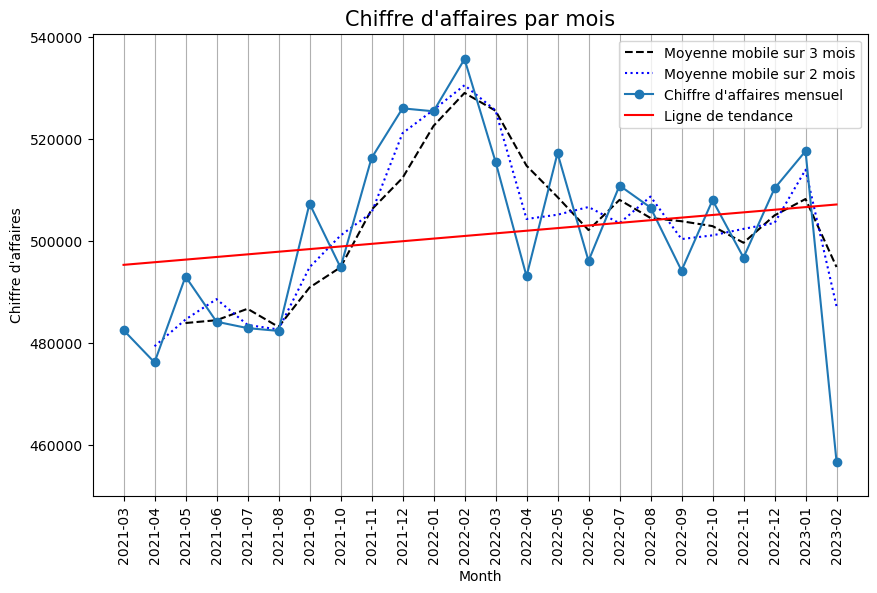

In [22]:
# Créer une courbe et les moyennes mobile
plt.figure(figsize=(10, 6))
plt.plot(ca_par_mois['month_year'], ca_par_mois['moving_average_3'], linestyle='--', color='black', label='Moyenne mobile sur 3 mois')
plt.plot(ca_par_mois['month_year'], ca_par_mois['moving_average_2'], linestyle='dotted', color='blue', label='Moyenne mobile sur 2 mois')
plt.plot(ca_par_mois['month_year'], ca_par_mois['price'], marker='o', linestyle='-', label="Chiffre d'affaires mensuel")
plt.xlabel('Month')
plt.ylabel("Chiffre d'affaires")
plt.title("Chiffre d'affaires par mois", size=15)
plt.xticks(rotation=90)
plt.grid(axis='x')

#Ajouter une ligne de tendance
x = np.arange(len(ca_par_mois['month_year']))
slope, intercept = np.polyfit(np.arange(len(ca_par_mois['month_year'])), ca_par_mois['price'], 1)
trend_line = slope * x + intercept
plt.xlim(left=-1, right=len(ca_par_mois['month_year']))
plt.ylim(450000, max(ca_par_mois['price'])+5000) 
plt.plot(x, trend_line, color='red', label='Ligne de tendance')

plt.legend()

plt.show()

In [23]:
#Séparer lignes des données par catégories
cat_0 = ca.loc[ca['categ']==0]
cat_1 = ca.loc[ca['categ']==1]
cat_2 = ca.loc[ca['categ']==2]

#Créer un tableau montrant le chiffre d'affaires mensuel
cat_0_par_mois = cat_0.groupby(['month_year'])['price'].sum().reset_index()
cat_0_par_mois['moving_average'] = cat_0_par_mois['price'].rolling(window=3).mean()

cat_1_par_mois = cat_1.groupby(['month_year'])['price'].sum().reset_index()
cat_1_par_mois['moving_average'] = cat_1_par_mois['price'].rolling(window=3).mean()

cat_2_par_mois = cat_2.groupby(['month_year'])['price'].sum().reset_index()
cat_2_par_mois['moving_average'] = cat_2_par_mois['price'].rolling(window=3).mean()

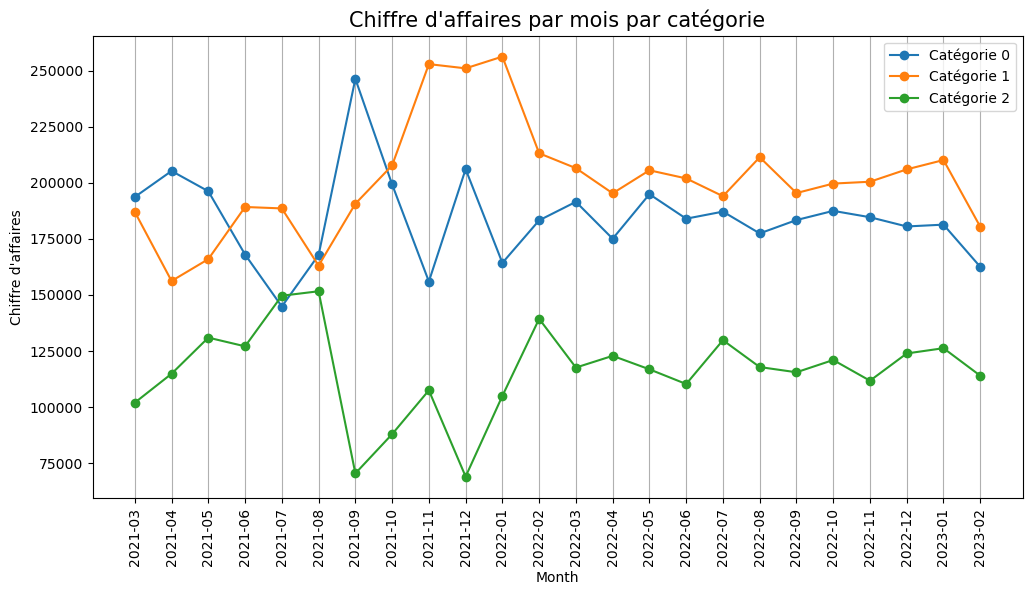

In [24]:
#Créer une graphique avec le CA par mois
plt.figure(figsize=(12, 6))
plt.plot(cat_0_par_mois['month_year'], cat_0_par_mois['price'], marker='o', linestyle='-', label="Catégorie 0")
plt.plot(cat_1_par_mois['month_year'], cat_1_par_mois['price'], marker='o', linestyle='-', label="Catégorie 1")
plt.plot(cat_2_par_mois['month_year'], cat_2_par_mois['price'], marker='o', linestyle='-', label="Catégorie 2")
plt.xlabel('Month')
plt.ylabel("Chiffre d'affaires")
plt.title("Chiffre d'affaires par mois par catégorie", size=15)
plt.xticks(rotation=90)
plt.grid(axis='x')
plt.legend()
plt.show()

In [25]:
#Joigner produits et transactions
produits_transactions = pd.merge(transactions, produits, on='id_prod', how='left')
produits_transactions.head()

,id_prod,session_id,client_id,dateextract,price,categ
0,0_1259,s_1,c_329,2021-03-01,11.99,0
1,0_1390,s_2,c_664,2021-03-01,19.37,0
2,0_1352,s_3,c_580,2021-03-01,4.50,0
3,0_1458,s_4,c_7912,2021-03-01,6.55,0
4,0_1358,s_5,c_2033,2021-03-01,16.49,0


Text(0.5, 1.0, "Pourcentage du chiffre d'affaires total par catégorie")

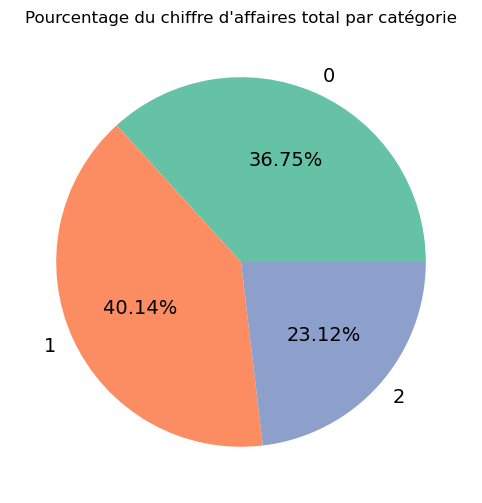

In [26]:
# Chiffre d'affaires par catégorie
ca_categ = produits_transactions.groupby(['categ'])['price'].sum().reset_index()
ca_categ = ca_categ.rename(columns ={'price':'chiffre_daffaires'})

#Camembert qui montre les chiffre d'affaires par catégorie
plt.figure(figsize=(8, 6))
plt.pie(x= ca_categ['chiffre_daffaires'], labels = ca_categ['categ'], autopct='%.2f%%', textprops={'fontsize': 14}, colors=sns.color_palette('Set2'))
plt.title("Pourcentage du chiffre d'affaires total par catégorie", size=12)

In [27]:
# Nombre de ventes par catégorie
produits_categ = produits_transactions.groupby(['categ'])['id_prod'].nunique().reset_index()

# Fusionner ca_categ et produits_categ
categ_ventes_ca = pd.merge(ca_categ, produits_categ, on='categ', how='inner')
categ_ventes_ca = categ_ventes_ca.rename(columns ={'id_prod':'nombre_produits'})

#Determiner le chiffre d'affaires moyen par produit pour chaque catégorie
categ_ventes_ca['ca_moyen_par_produit'] = categ_ventes_ca['chiffre_daffaires']/categ_ventes_ca['nombre_produits']

categ_ventes_ca

,categ,chiffre_daffaires,nombre_produits,ca_moyen_par_produit
0,0,4419730.97,2292,1928.329394
1,1,4827657.11,737,6550.416703
2,2,2780275.02,236,11780.826356


Il est intéressant de noter que même s'il n'y a que 236 produits dans la catégorie 2 (contre 2292 dans la catégorie zéro et 737 dans la catégorie 1), cela représente tout de même 23,12 pour cent de notre CA.

De plus, il est intéressant de noter que même si la catégorie 2 a le chiffre d'affaires le plus bas, elle a également le chiffre d'affaires moyen par produit le plus élevé. Il convient de vérifier le prix moyen pour chaque catégorie et s'il existe des valeurs aberrantes en matière de prix.

### Faire un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.

In [28]:
#Créer dataframe avec nombre de produits vendu pour chaque id_prod
produits_vendus = produits_transactions.groupby(['categ','id_prod'])['session_id'].count().reset_index()
produits_vendus = produits_vendus.rename(columns={'session_id':'produits_vendus'})
produits_vendus = produits_vendus.sort_values('produits_vendus', ascending=False)

Text(0.5, 1.0, 'Pourcentage des ventes totales par catégorie')

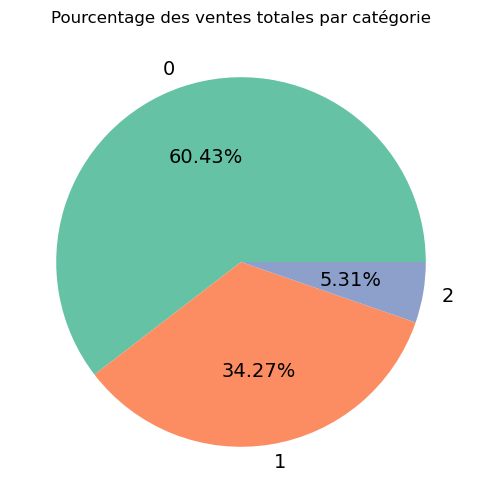

In [29]:
# Determiner nombre de ventes par catégorie
produits_compte = produits_vendus.groupby('categ')['produits_vendus'].sum().reset_index()

#Camembert qui montre les nombres des ventes par catégore
plt.figure(figsize=(8, 6))
plt.pie(x= produits_compte['produits_vendus'], labels = produits_compte['categ'], autopct='%.2f%%', textprops={'fontsize': 14}, colors=sns.color_palette('Set2'))
plt.title("Pourcentage des ventes totales par catégorie", size=12)

In [30]:
# Determiner nombre de ventes par produit
produits_vendus_categ = produits_vendus.groupby('categ')['id_prod'].count().reset_index().rename(columns={'id_prod':'nombre_de_produits'})
produits_vendus_nombre = pd.merge(produits_compte, produits_vendus_categ, on='categ', how='inner')

# Determiner moyen nombre de ventes par produit pour chaque catégorie
produits_vendus_nombre['moyen_ventes_par_produit'] = produits_vendus_nombre['produits_vendus']/produits_vendus_nombre['nombre_de_produits']
produits_vendus_nombre

,categ,produits_vendus,nombre_de_produits,moyen_ventes_par_produit
0,0,415459,2292,181.264834
1,1,235592,737,319.663501
2,2,36483,236,154.588983


#### Les produits les plus populaires

La catégorie 0 représente la grande majorité des produits avec une seule vente. La catégorie 2 ne contient aucun produit avec une seule vente.

In [31]:
produits_vendus_sorted = produits_vendus.sort_values('produits_vendus', ascending=False)
top_10_ventes = produits_vendus_sorted.head(10)
pire_10_ventes = produits_vendus_sorted.tail(10)

#Top 10 et pire 10 par catégorie
ventes_sorted_0 = produits_vendus_sorted.loc[produits_vendus_sorted['categ']==0]
ventes_sorted_1 = produits_vendus_sorted.loc[produits_vendus_sorted['categ']==1]
ventes_sorted_2 = produits_vendus_sorted.loc[produits_vendus_sorted['categ']==2]

#Top 10 par catégorie
ventes_top_10_0 = ventes_sorted_0.head(10)
ventes_top_10_1 = ventes_sorted_1.head(10)
ventes_top_10_2 = ventes_sorted_2.head(10)


In [32]:
def crée_graphique(dataframe, title):
    plt.figure(figsize=(25, 3))
    graph = sns.barplot(data=dataframe, x='id_prod', y='produits_vendus', errorbar=None, estimator=sum)
    plt.title(title, size=20)
    plt.xlabel("Identifiant du produit", size=18)
    plt.xticks(fontsize=15)
    plt.ylabel("Ventes totales", size=18)
    plt.yticks(fontsize=15)
    plt.ylim([0, 3000])
    sns.set_palette(palette='Set2')
    

    for i in graph.containers:
        graph.bar_label(i, fontsize=15)

    plt.show()

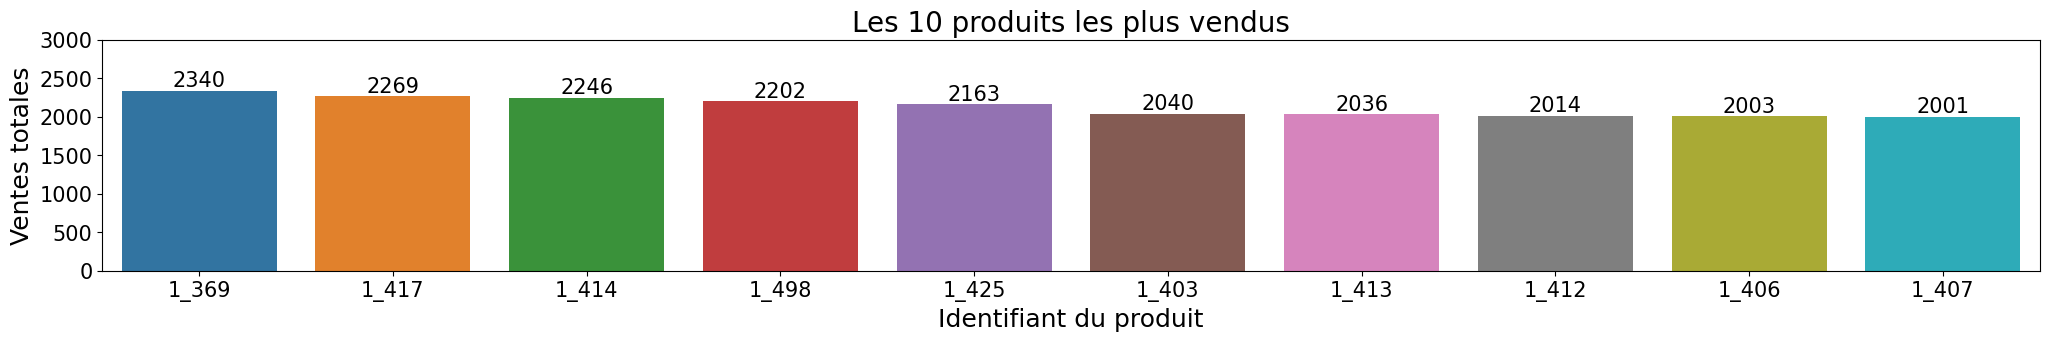

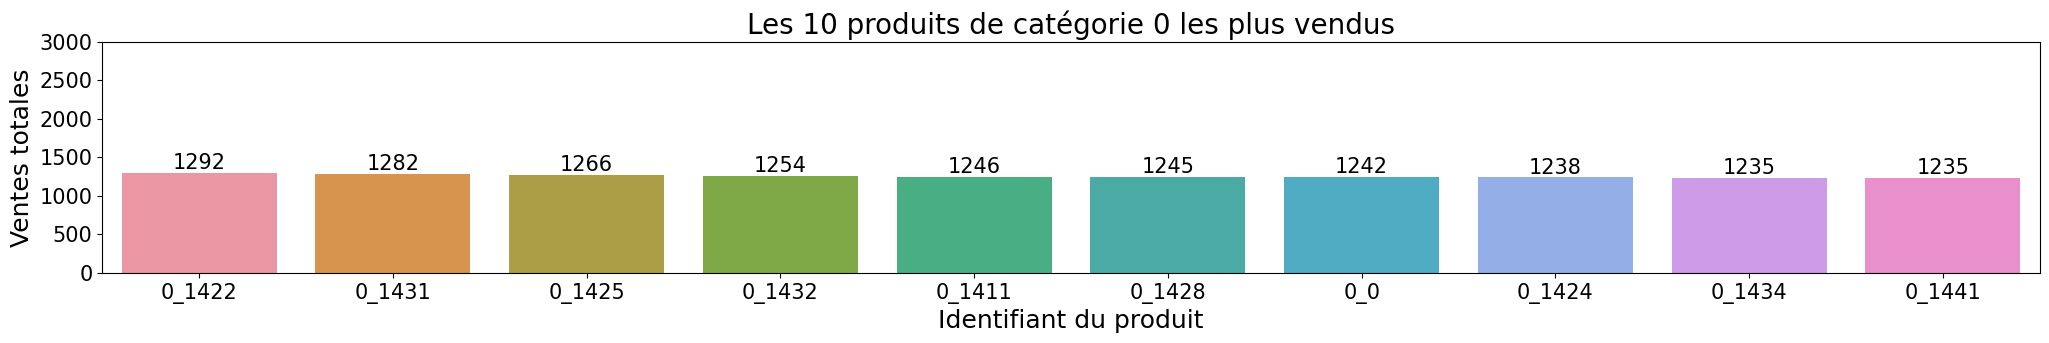

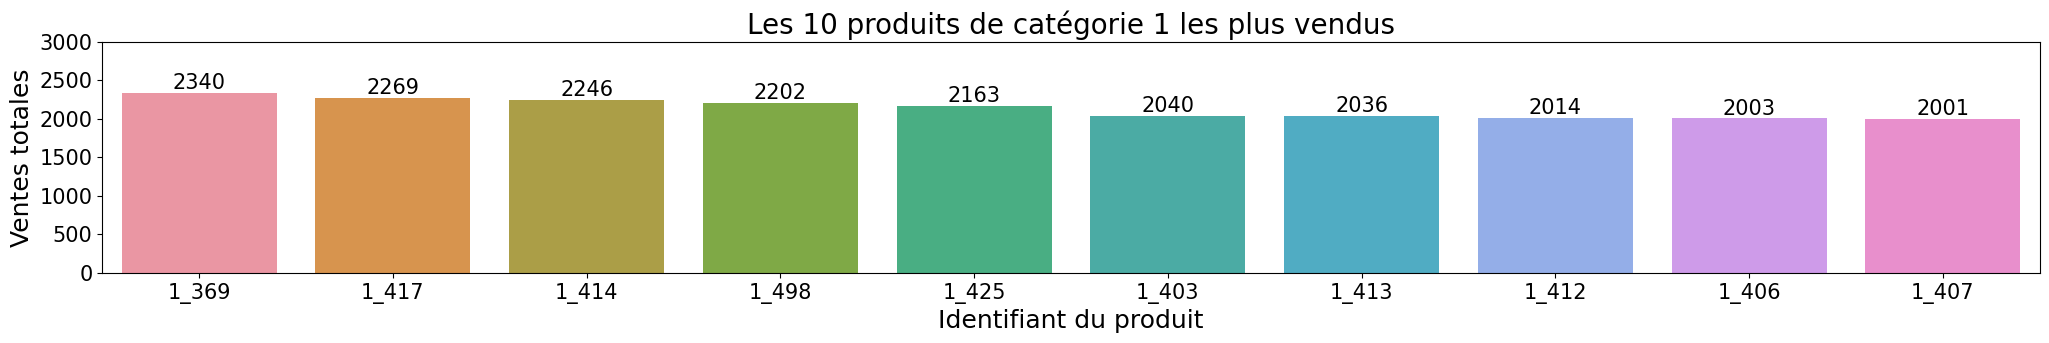

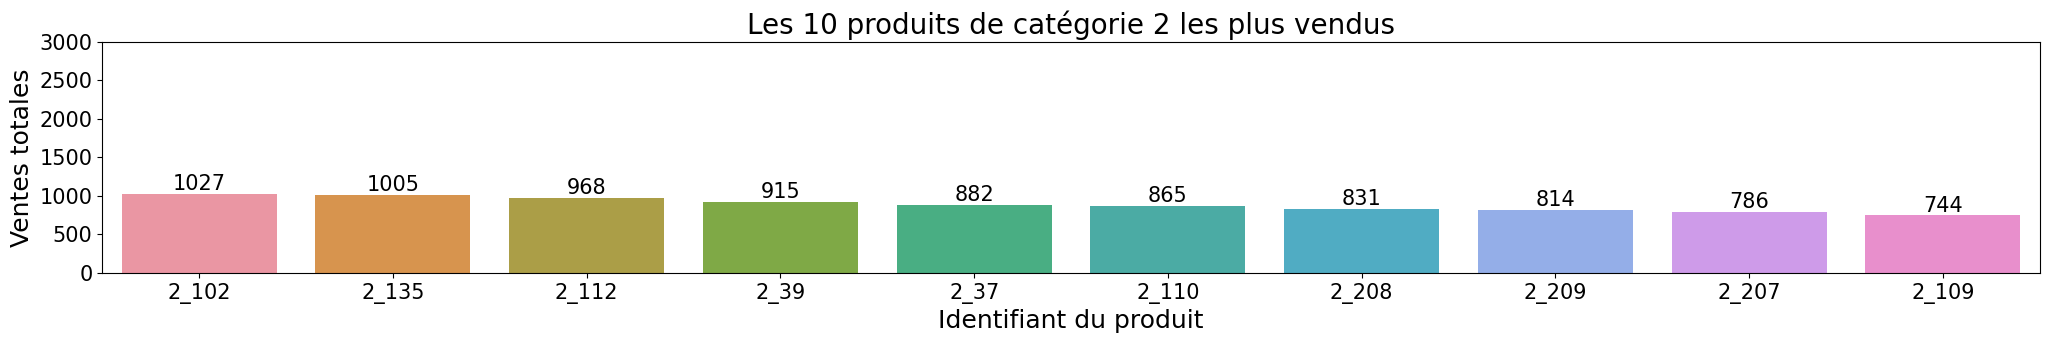

In [33]:
#Graphiques du top 10 et pire 10 
crée_graphique(top_10_ventes, "Les 10 produits les plus vendus")

#Graphiques du top 10 et pire 10 par catégorie 0
crée_graphique(ventes_top_10_0, "Les 10 produits de catégorie 0 les plus vendus")

#Graphiques du top 10 et pire 10 par catégorie 1
crée_graphique(ventes_top_10_1, "Les 10 produits de catégorie 1 les plus vendus")

#Graphiques du top 10 et pire 10 par catégorie 2
crée_graphique(ventes_top_10_2, "Les 10 produits de catégorie 2 les plus vendus")

In [34]:
sorted_ventes_produits = transactions.groupby('id_prod')['client_id'].count().reset_index().sort_values('client_id', ascending=False).rename(columns={'client_id':'nombre_ventes'})
print("Le nombre moyen d'achats effectués pour chaque produit est", round(sorted_ventes_produits['nombre_ventes'].mean(),0),"- cependant, les 10 produits les plus vendus en termes de ventes vendent environ 10 fois plus d'unités.")

Le nombre moyen d'achats effectués pour chaque produit est 211.0 - cependant, les 10 produits les plus vendus en termes de ventes vendent environ 10 fois plus d'unités.


#### Les produits les moins populaires (par ventes)

In [35]:
#Trouver le nombre des ventes vendu une seule fois
une_vente = (produits_vendus.loc[produits_vendus['produits_vendus']==1])
nombre_une_vente = une_vente['produits_vendus'].count()
categ_0_une_vente = (produits_vendus['produits_vendus'].loc[(produits_vendus['produits_vendus']==1) & (produits_vendus['categ']==0)]).count()
categ_1_une_vente = (produits_vendus['produits_vendus'].loc[(produits_vendus['produits_vendus']==1) & (produits_vendus['categ']==1)]).count()
categ_2_une_vente = (produits_vendus['produits_vendus'].loc[(produits_vendus['produits_vendus']==1) & (produits_vendus['categ']==2)]).count()


print("Il y a", nombre_une_vente, "produits qui n'ont été vendus qu'une seule fois.")
print('---')
print(categ_0_une_vente, "produits de la catégorie 0 n'ont été vendus qu'une seule fois")
print(categ_1_une_vente, "produits de la catégorie 1 n'ont été vendus qu'une seule fois")
print(categ_2_une_vente, "produits de la catégorie 2 n'ont été vendus qu'une seule fois")

Il y a 18 produits qui n'ont été vendus qu'une seule fois.
---
15 produits de la catégorie 0 n'ont été vendus qu'une seule fois
0 produits de la catégorie 1 n'ont été vendus qu'une seule fois
3 produits de la catégorie 2 n'ont été vendus qu'une seule fois


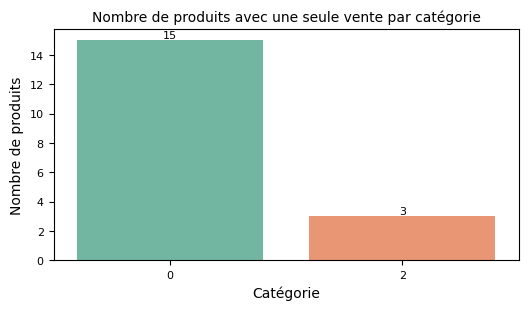

In [36]:
#Faire une graphique qui montre les nombres des produits avec une seule vente par catégorie
une_vente_categ = une_vente.groupby('categ')['produits_vendus'].sum().reset_index()

plt.figure(figsize=(6, 3))
graph = sns.barplot(data=une_vente_categ, x='categ', y='produits_vendus', errorbar=None, estimator=sum)
plt.title("Nombre de produits avec une seule vente par catégorie", size=10)
plt.xlabel("Catégorie", size=10)
plt.xticks(fontsize=8)
plt.ylabel("Nombre de produits", size=10)
plt.yticks(fontsize=8)

for i in graph.containers:
    graph.bar_label(i, fontsize=8)

#### Les produits avec les plus grands et les plus petits chiffre d'affaires

In [37]:
#Créer les dataframes qui montre les produits avec les plus grands et plus petits chiffre d'affaires

ca_categories_sorted = produits_transactions.groupby(['id_prod', 'categ'])['price'].sum().reset_index()
ca_categories_sorted = ca_categories_sorted.sort_values('price', ascending=False)
top_10 = ca_categories_sorted.head(10)
pire_10 = ca_categories_sorted.tail(10)

In [38]:
#Créer une function afin de créer les graphiques
def crée_graphique(dataframe, title):
    plt.figure(figsize=(25, 12))
    graph = sns.barplot(data=dataframe, x='id_prod', y='price', errorbar=None, estimator=sum)
    plt.title(title, size=33)
    plt.xlabel("Identifiant du produit", size=30)
    plt.xticks(fontsize=23)
    plt.ylabel("Chiffre d'affaires", size=30)
    plt.yticks(fontsize=23)
    sns.set_palette(palette='Set2')

    for i in graph.containers:
        graph.bar_label(i, fontsize=20)

    plt.show()

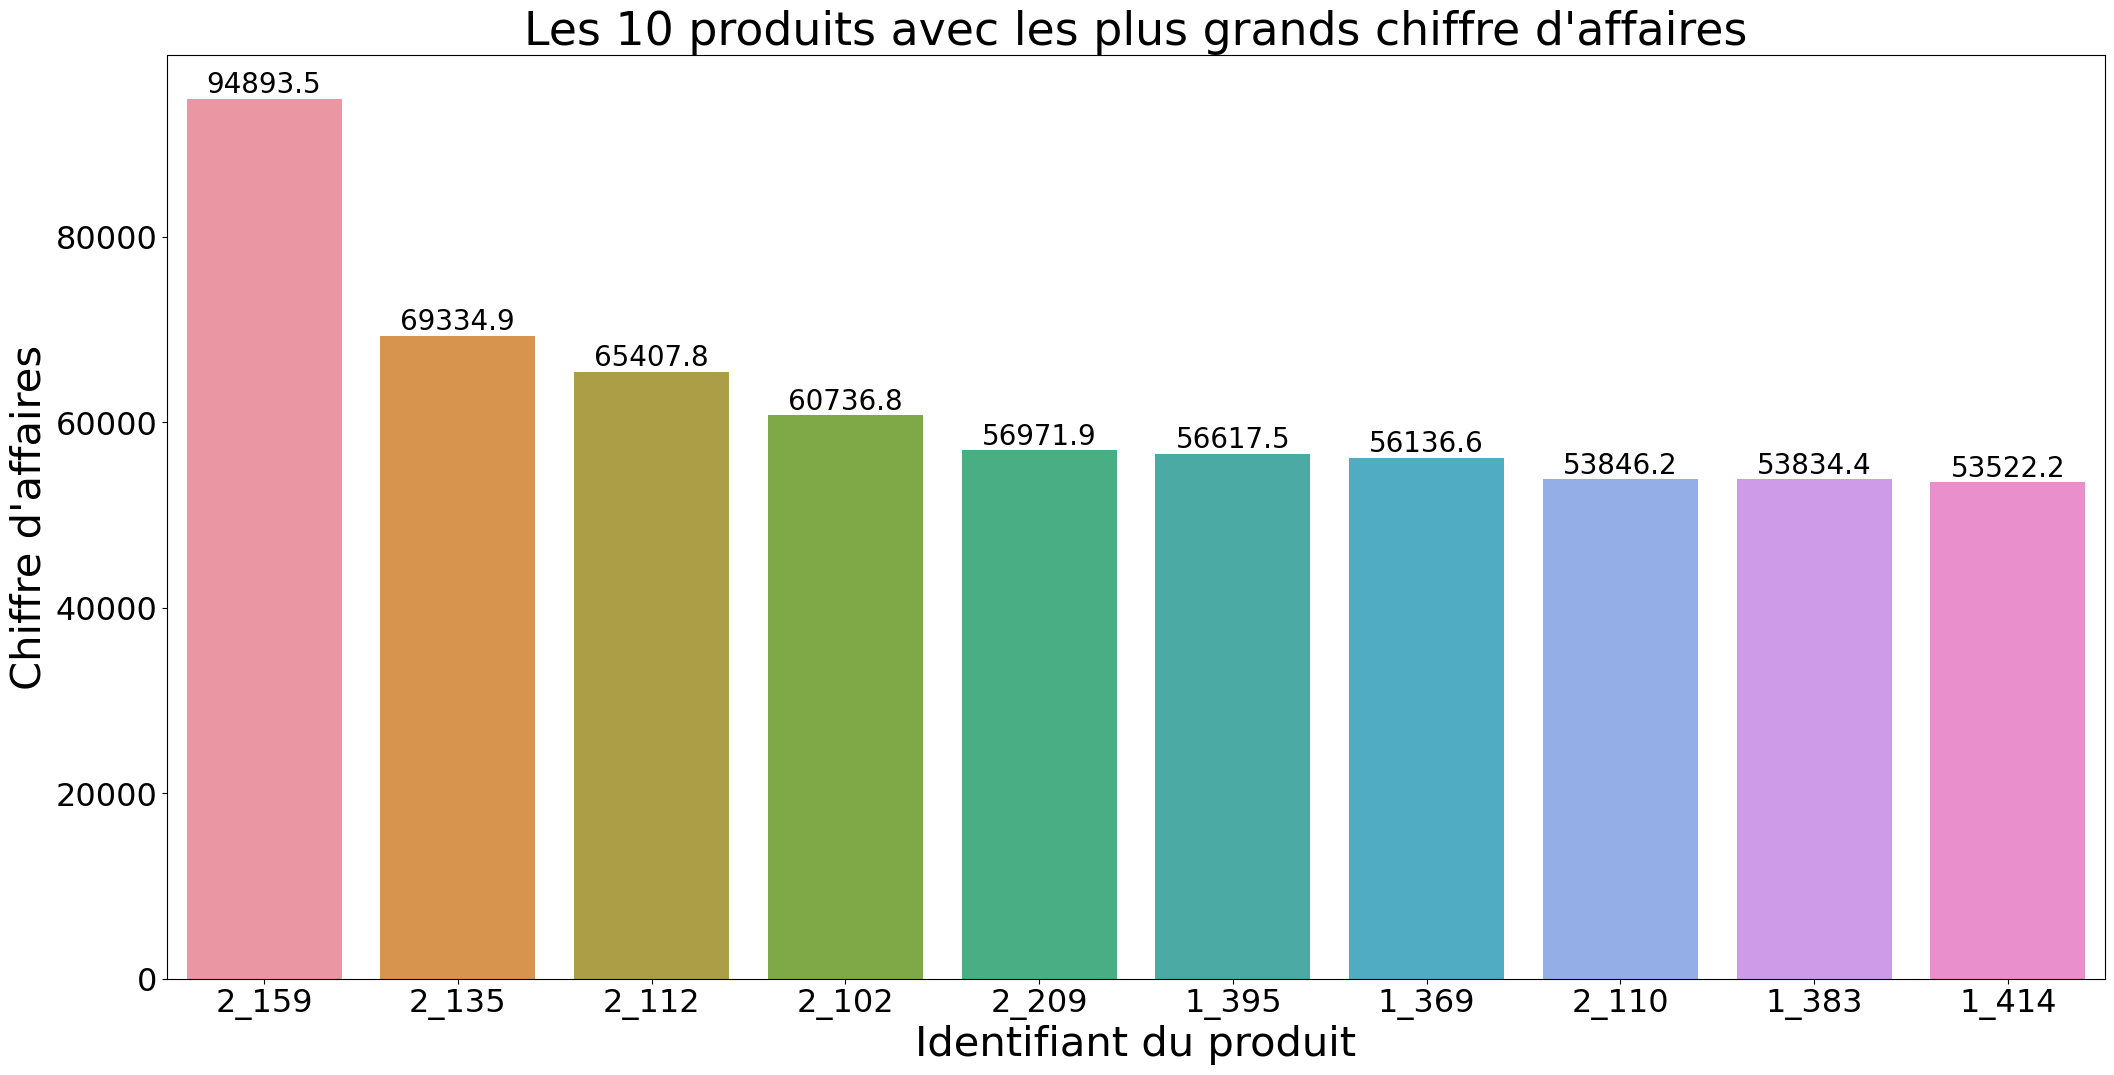

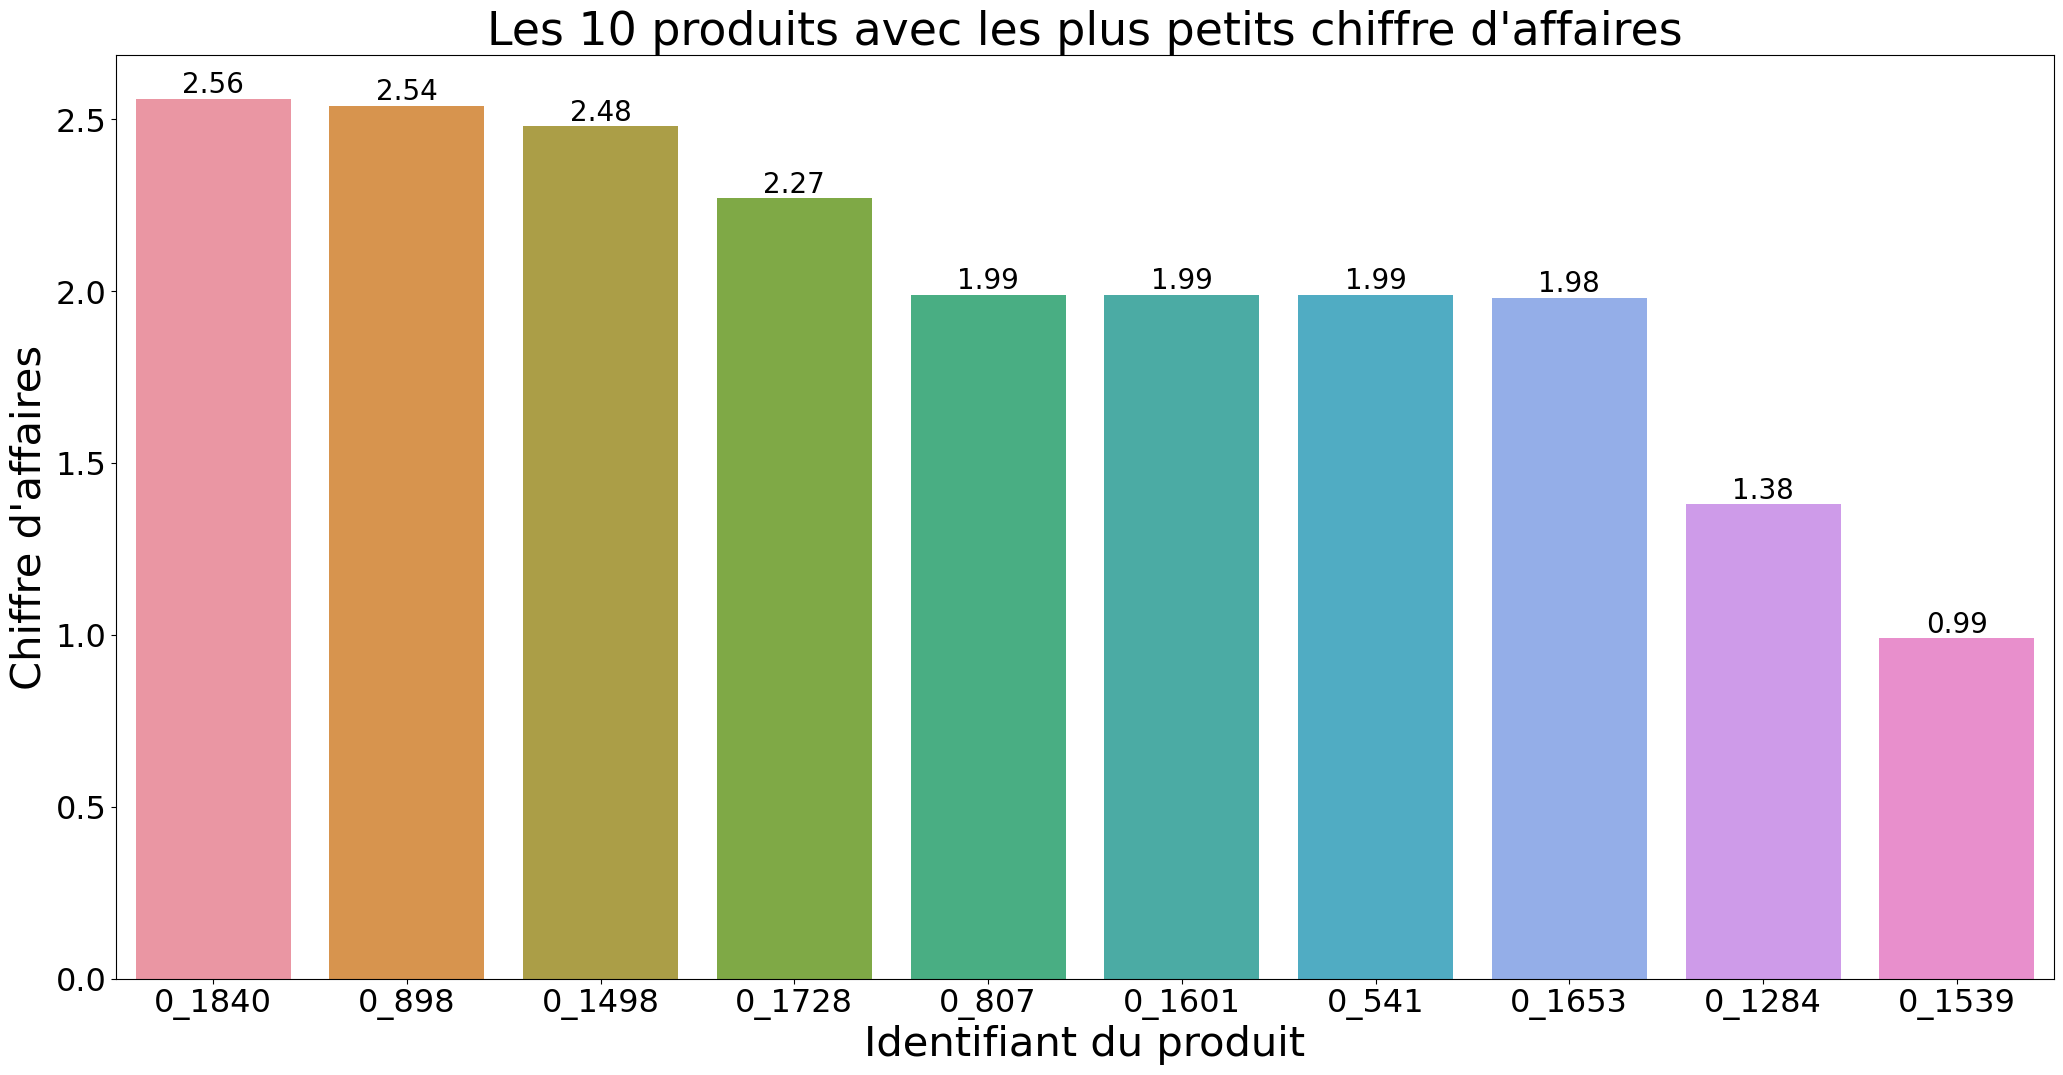

In [39]:
#Graphiques du top 10 et pire 10 
crée_graphique(top_10, "Les 10 produits avec les plus grands chiffre d'affaires")
crée_graphique(pire_10, "Les 10 produits avec les plus petits chiffre d'affaires")


6 des produits avec les plus grands chiffres d'affaires sont du catégorie 2. 4 viennent de la catégorie 1, et rien ne vient du catégorie 0. Par contre, les 10 produits avec les plus petits chiffres d'affaires tous viennent de la catégorie 0.

### Quelques informations sur les profils de nos clients, et également la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz.

#### Les profils de nos clients

In [40]:
# Montrer combien de clients sont des femmes et combien sont des hommes
print('Nombre de clients masculins =', clients.loc[clients['sex']=='m','client_id'].count())
print('Nombre de clients feminins =', clients.loc[clients['sex']=='f','client_id'].count())

Nombre de clients masculins = 4131
Nombre de clients feminins = 4490


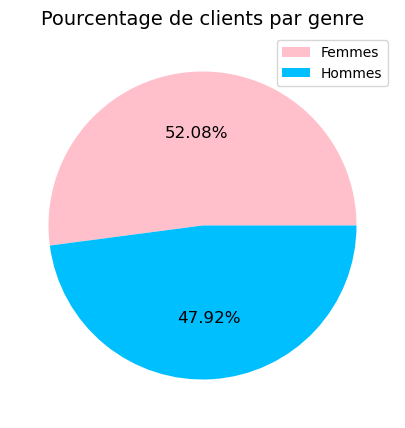

In [41]:
# Camembert qui montre la répartition par sexe
count_clients = clients.groupby('sex')['client_id'].nunique().reset_index()

plt.figure(figsize=(6, 5))
plt.pie(x= count_clients['client_id'], autopct='%.2f%%', textprops={'fontsize': 12}, colors=['pink', 'deepskyblue'])
plt.title("Pourcentage de clients par genre", size=14)
plt.legend(labels = ['Femmes', 'Hommes'])

Nous avons 4490 clients féminins et 4131 clients masculins. Cela signifie une différence de 4,16 pour cent.

In [42]:
#Créer la colonne 'age'
clients['age'] = 2023 - clients['birth']

#Regarder le data pour age
print('Médiane année de naissance =', clients['age'].median())
print('Mode année de naissance =', clients['age'].mode())
display(clients.describe())

Médiane année de naissance = 44.0
Mode année de naissance = 0    19
Name: age, dtype: int64


,birth,age
count,8621.000000,8621.000000
mean,1978.275606,44.724394
std,16.917958,16.917958
min,1929.000000,19.000000
25%,1966.000000,31.000000
50%,1979.000000,44.000000
75%,1992.000000,57.000000
max,2004.000000,94.000000


Il sera plus facile d'examiner les données d'âge si je regroupe les années de naissance. Cela me permettra également d’identifier plus facilement les tendances.

In [43]:
#Créer groupes d'age
age_bins = [18, 23, 27, 31, 35, 39, 43, 47 ,51, 55, 59 ,63, 67, 71, 75, 79, 83, 87, 91, 95]
age_labels = ['19-23', '24-27','28-31','32-35','36-39','40-43','44-47','48-51','52-55','56-59','60-63','64-67','68-71','72-75','76-79','80-83','84-87',
                   '88-91','92-95',]
clients['groupe_dage'] = pd.cut(clients['age'], bins=age_bins, labels=age_labels)

#Créer dataframe avec groupes d'age
clients_age_genre = clients.groupby(['groupe_dage', 'sex'])['client_id'].nunique().reset_index()

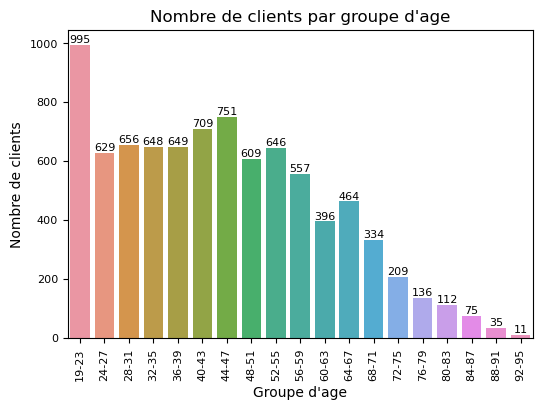

In [44]:
# Graphique du nombre de clients par age
plt.figure(figsize=(6, 4))
graph = sns.barplot(data=clients_age_genre, x='groupe_dage', y='client_id', errorbar=None, estimator=sum)
plt.title("Nombre de clients par groupe d'age", size=12)
plt.xlabel("Groupe d'age", size=10)
plt.xticks(fontsize=8)
plt.ylabel("Nombre de clients", size=10)
plt.yticks(fontsize=8)
plt.xticks(rotation=90)

for i in graph.containers:
    graph.bar_label(i, fontsize=8)

Il n'est peut-être pas surprenant que notre entreprise compte très peu de clients nés avant 1949. Alors que les personnes âgées de 75 ans et plus représentent 10 % de la population française (https://www.statista.com/statistics/464032/distribution-population-age-group -france/), ils sont moins susceptibles d'avoir des connaissances en informatique.

La tranche d'âge qui effectue le plus d'achats (995) est celle des 19-23 ans. Ce groupe d'âge possède de très bonnes connaissances en informatique et est probablement très à l'aise avec les achats en ligne.

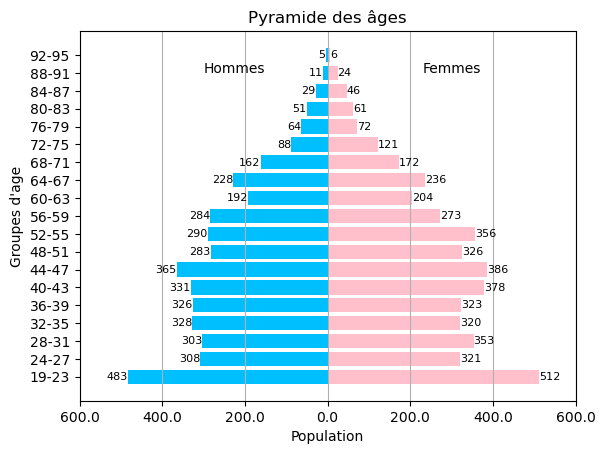

In [45]:
#Créer une pyramide des ages

clients_age_pyramide = clients_age_genre.pivot_table(index='groupe_dage', columns='sex', values='client_id', aggfunc='sum').reset_index()

fig, ax = plt.subplots()

ax.barh(clients_age_pyramide['groupe_dage'], -clients_age_pyramide['m'], color='deepskyblue')
ax.barh(clients_age_pyramide['groupe_dage'], clients_age_pyramide['f'], color='pink')

ax.set_xlabel('Population')
ax.set_ylabel("Groupes d'age")
ax.set_title('Pyramide des âges')

ax.set_xticks(ax.get_xticks()[::1])
ax.set_xticklabels([abs(tick) for tick in ax.get_xticks()[::1]])

for i, (m, f, groupe_dage) in enumerate(zip(clients_age_pyramide['m'], clients_age_pyramide['f'], clients_age_pyramide['groupe_dage'])):
    ax.text(-m, i, f"{abs(m)}", ha='right', va='center', fontsize=8)
    ax.text(f, i, f"{abs(f)}", ha='left', va='center', fontsize=8)

plt.text(-300, 17, "Hommes", fontsize=10)
plt.text(230, 17, "Femmes", fontsize=10)
plt.grid(axis='x')

plt.show()


16 sur les 19 groupes d'âge ont plus femmes qu'hommes. Mais, pour la plupart, la différence n'est pas très grande.

### Courbe de Lorenz

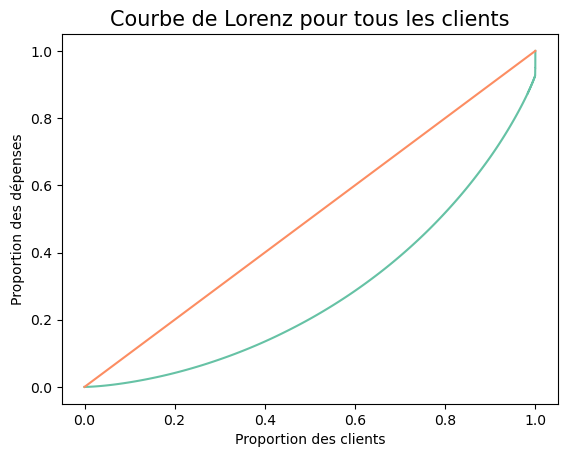

L'indice de Gini =  0.44189587995615665


In [46]:
#Faire la courbe de Lorenz - tous les clients
clients_dépenses = ca.groupby('client_id')['price'].sum().reset_index().rename(columns={'price':'dépenses'})
clients_dép = clients_dépenses['dépenses'].values
n = len(clients_dép)
lorenz = np.cumsum(np.sort(clients_dép)) / clients_dép.sum()
lorenz = np.append([0],lorenz) 

plt.title("Courbe de Lorenz pour tous les clients", size=15)
plt.xlabel("Proportion des clients", size=10)
plt.ylabel("Proportion des dépenses", size=10)
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.plot([0,1], [0,1])
plt.show()


#Faire l'indice de Gini
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n 
S = 0.5 - AUC
gini = 2*S
print("L'indice de Gini = ", gini) 

Un indice de Gini de 0,44 suggère que les dépenses des clients sont inégalement réparties.

La courbe de Lorenz montre que nos 20 pour cent de clients les plus importants représentent environ 50 pour cent de notre chiffre d'affaires. En outre, les 50 pour cent de clients les plus pauvres ne représentent qu'environ 20 pour cent de nos chiffres d'affaires totaux.

### Top Clients

In [47]:
#Trouver top 5% des clients et top 10 clients par dépenses
clients_dépenses_sort = clients_dépenses.sort_values('dépenses', ascending=False)
top_clients_5 = clients_dépenses_sort.head(430)
top_10_CA = top_clients_5.head(10)
top_10_CA

,client_id,dépenses
677,c_1609,326039.89
4388,c_4958,290227.03
6337,c_6714,153918.60
2724,c_3454,114110.57
634,c_1570,5285.82
2513,c_3263,5276.87
1268,c_2140,5260.18
2108,c_2899,5214.05
7006,c_7319,5155.77
7715,c_7959,5135.75


In [48]:
print("Chiffre d'affaires des top 5% des clients = €", top_clients_5['dépenses'].sum())
print('---')
print("Les 5% plus dépensiers (430 clients) représentent", round((top_clients_5['dépenses'].sum()/clients_dépenses['dépenses'].sum())*100,2), "% de notre chiffre d'affaires")
print('---')
print("Les 5 % des plus dépensiers ont un CA moyen de", round(top_clients_5['dépenses'].mean(),2), "€ par personne. Cependant, le CA moyen global par personne n'est que de €", round(clients_dépenses['dépenses'].mean(),2))

Chiffre d'affaires des top 5% des clients = € 2529402.05
---
Les 5% plus dépensiers (430 clients) représentent 21.03 % de notre chiffre d'affaires
---
Les 5 % des plus dépensiers ont un CA moyen de 5882.33 € par personne. Cependant, le CA moyen global par personne n'est que de € 1398.57


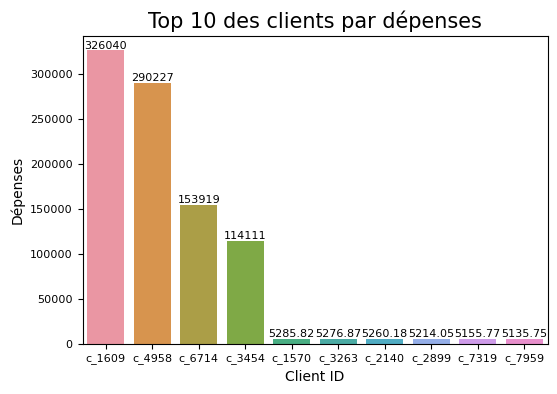

In [49]:
# Graphique des top 10 des clients par dépenses
plt.figure(figsize=(6, 4))
graph = sns.barplot(data=top_10_CA, x='client_id', y='dépenses', errorbar=None, estimator=sum)
plt.title("Top 10 des clients par dépenses", size=15)
plt.xlabel("Client ID", size=10)
plt.xticks(fontsize=8)
plt.ylabel("Dépenses", size=10)
plt.yticks(fontsize=8)

for i in graph.containers:
    graph.bar_label(i, fontsize=8)

Il y a 4 clients qui ont dépensé nettement plus que les autres clients (plus de 100 000 euros). Il s’agit probablement de clients professionnels qui achètent des livres en gros.

### Top 10 des clients par fréquence d'achats

In [50]:
#Trouver top 10 clients par fréquence d'achats
clients_achats = transactions.groupby('client_id')['session_id'].count().reset_index().sort_values('session_id', ascending=False).rename(columns={'session_id':'nombre_dachats'})
top_10_achats = clients_achats.head(10)

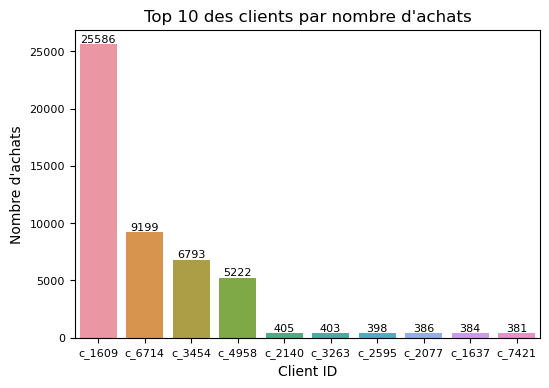

In [51]:
# Graphique des top 10 des clients par fréquence d'achats
plt.figure(figsize=(6, 4))
graph = sns.barplot(data=top_10_achats, x='client_id', y='nombre_dachats', errorbar=None, estimator=sum)
plt.title("Top 10 des clients par nombre d'achats", size=12)
plt.xlabel("Client ID", size=10)
plt.xticks(fontsize=8)
plt.ylabel("Nombre d'achats", size=10)
plt.yticks(fontsize=8)

for i in graph.containers:
    graph.bar_label(i, fontsize=8)

In [52]:
#Trouver les clients qui font partie du top 10 des dépensiers mais aussi des 10 premiers clients en termes d'achats
pd.merge(top_10_achats, top_10_CA, on='client_id', how='inner')

,client_id,nombre_dachats,dépenses
0,c_1609,25586,326039.89
1,c_6714,9199,153918.60
2,c_3454,6793,114110.57
3,c_4958,5222,290227.03
4,c_2140,405,5260.18
5,c_3263,403,5276.87


6 de nos 10 premiers clients en termes de dépenses sont également parmi les 10 premiers clients en termes de nombre d'achats effectués. Ceux-ci incluent nos 4 gros dépensiers, ainsi que les identifiants client c_2140 et c_3263.

Le client 1609 dépense le plus de tous nos clients et effectue également les achats les plus fréquents.

### Toutes les informations et tous graphiques qui apporteraient de l’information pertinente  - Top 10 des clients par catégorie

In [53]:
#Créer dataframe avec nombre d'achats par catégorie pour chaque client
prod_trans = pd.merge(produits, transactions, how='left', on='id_prod')
clients_categs = prod_trans.groupby(['client_id', 'categ'])['id_prod'].count().reset_index().rename(columns={'id_prod':'nombre_dachats'})

In [54]:
#Séparer par catégorie et trouver les top 10
top_10_clients_categs_0 = clients_categs.loc[clients_categs['categ']==0].sort_values('nombre_dachats', ascending=False).head(10)
top_10_clients_categs_1 = clients_categs.loc[clients_categs['categ']==1].sort_values('nombre_dachats', ascending=False).head(10)
top_10_clients_categs_2 = clients_categs.loc[clients_categs['categ']==2].sort_values('nombre_dachats', ascending=False).head(10)



In [55]:
def categ_client_graphique(dataframe, title):
    plt.figure(figsize=(5, 4))
    graph = sns.barplot(data=dataframe, x='client_id', y='nombre_dachats', errorbar=None, estimator=sum)
    plt.title(title, size=12)
    plt.xlabel("ID du client", size=11)
    plt.xticks(fontsize=10)
    plt.ylabel("Nombre d'achats", size=11)
    plt.yticks(fontsize=10)
    plt.xticks(rotation=90)
    sns.set_palette(palette='Set2')

    for i in graph.containers:
        graph.bar_label(i, fontsize=8)

    plt.show()

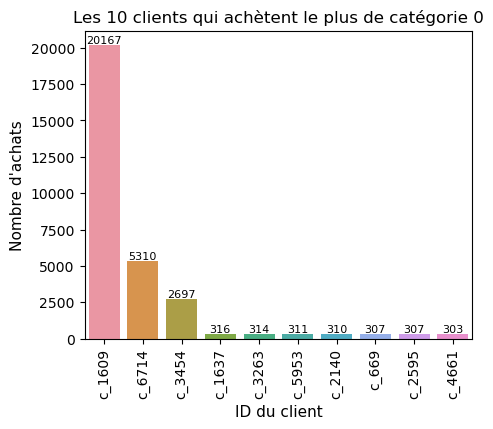

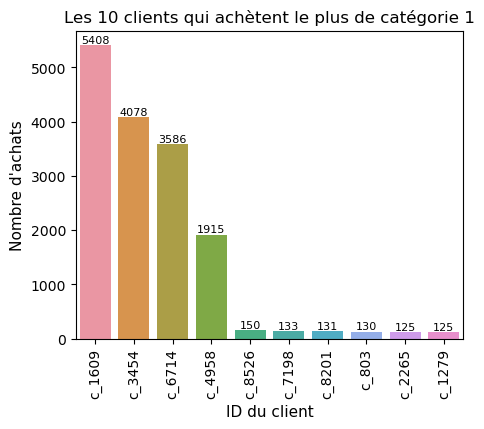

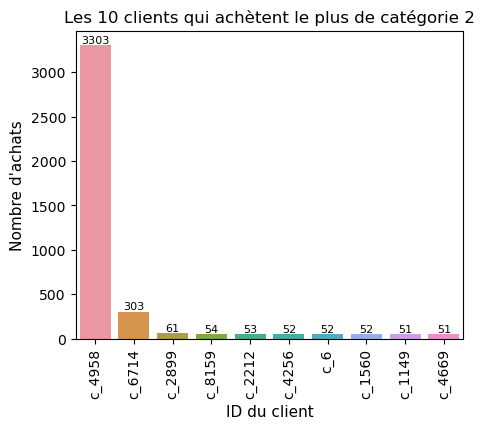

In [56]:
#Graphiques de top 10 clients pour chaque catégorie
categ_client_graphique(top_10_clients_categs_0, "Les 10 clients qui achètent le plus de catégorie 0")
categ_client_graphique(top_10_clients_categs_1, "Les 10 clients qui achètent le plus de catégorie 1")
categ_client_graphique(top_10_clients_categs_2, "Les 10 clients qui achètent le plus de catégorie 2")


In [57]:
#Vérifier s'il y a des clients qui apparaître dans tous les 3 listes des top 10 clients
premier_merge = pd.merge(top_10_clients_categs_0, top_10_clients_categs_1, on='client_id', how='inner')
pd.merge(premier_merge, top_10_clients_categs_2, on='client_id', how='inner')

,client_id,categ_x,nombre_dachats_x,categ_y,nombre_dachats_y,categ,nombre_dachats
0,c_6714,0,5310,1,3586,2,303


Seulement client 6714 apparait dans tous les graphiques qui montrent le top 10 clients pour chaque catégorie. Il est aussi dans le top 10 pour dépenses et nombre d'achats. 

In [58]:
total_achats_categ_2 = clients_categs.loc[clients_categs['categ']==2]
total_achats_categ_2 = total_achats_categ_2['nombre_dachats'].sum()
print("Le top client de catégorie 2 (4958) achète", round(3303/total_achats_categ_2*100, 2), "% de nos ventes totales de catégorie 2")

Le top client de catégorie 2 (4958) achète 9.05 % de nos ventes totales de catégorie 2


In [59]:
#Vérifier s'il le client 1609 a acheté des produits de catégorie 2
clients_categs.loc[clients_categs['client_id']=='c_1609']

,client_id,categ,nombre_dachats
1556,c_1609,0,20167
1557,c_1609,1,5408
1558,c_1609,2,11


- Bien que le client 1609 dépense le plus de tous nos clients et effectue également les achats les plus fréquents, il achète seulement 11 produits de catégorie 2. 
- Le client 6714 est le seul client qui apparaître dans tous les 3 listes du top 10 de la catégorie.

# PART 2 - A more customer-targeted analysis

In [60]:
#Créer df avec tous les fichiers
tous_dfs = pd.merge(transactions, produits, on='id_prod', how='left')
tous_dfs = pd.merge(tous_dfs, clients, on='client_id', how='left')

#### Genre d’un client et les catégories des livres achetés

- Hypothèse nulle (H0) : Aucune association entre le genre et la catégorie de livres achetés.
- Hypothèse alternative (H1) : Il existe une association entre le genre et la catégorie de livres achetés.

In [61]:
#Créer dataframe avec le sexe et le nombre des livres achetés pour chaque catégorie 
sexe_categs = tous_dfs.groupby(['sex', 'client_id', 'categ'])['id_prod'].count().reset_index().rename(columns={'id_prod':'produits_achetés'})


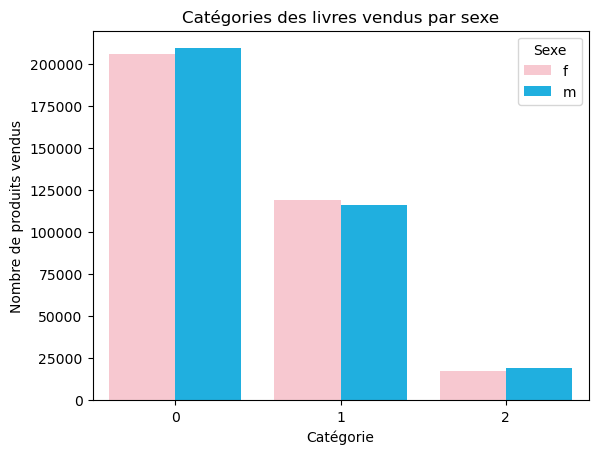

In [62]:
#Visualiser les nombre moyen d'achats pour chaque client par catégorie et genre.
sex_categs = tous_dfs.groupby(['sex', 'categ'])['id_prod'].count().reset_index()
sns.barplot(data=sex_categs, x='categ', y='id_prod', hue='sex', palette=['pink', 'deepskyblue'])
plt.title("Catégories des livres vendus par sexe")
plt.xlabel("Catégorie")
plt.ylabel("Nombre de produits vendus")
plt.legend(title='Sexe')
plt.show()

In [63]:
#Créer le tableau de contigence
tableau_de_contingence = pd.crosstab(tous_dfs['sex'], tous_dfs['categ'])
tableau_de_contingence

categ,0,1,2
sex,,,
f,206103,119307,17283
m,209356,116285,19200


In [64]:
khi2, p, dof, expected = stats.chi2_contingency(tableau_de_contingence)

print("Chi2 statistique =", khi2)
print("P-value =", p)
print("Dégré de liberté =",  dof)

Chi2 statistique = 158.25417617304882
P-value = 4.320582228399707e-35
Dégré de liberté = 2


Hypothèse alternative (H1) : Il existe une association entre le genre et la catégorie de livres achetés.

Un chi2 élevé et une valeur p très faible signifient que je dois rejeter l'hypothèse nulle. Il existe un lien entre le genre et la catégorie de livres achetés. Cependant, en réalité, la différence entre les catégories achetées n’est pas énorme, ce résultat peut donc ne pas être très utile en marketing.

#### Age et montant total

- H0 = L'age d'un client et le montant total d'achats ne sont pas liés
- H1 = L'age d'un client et le montant total d'achats sont liés

In [65]:
#Créer dataframe avec l'age et le montant total
age_dépenses = tous_dfs.groupby(['age', 'client_id'])['price'].sum().reset_index().rename(columns={'price':'dépenses_total'})

Pour l'age des clients
- H0 = Les ages des clients suivent une distribution normale
- H1 = Les ages des clients ne suivent pas une distribution normale

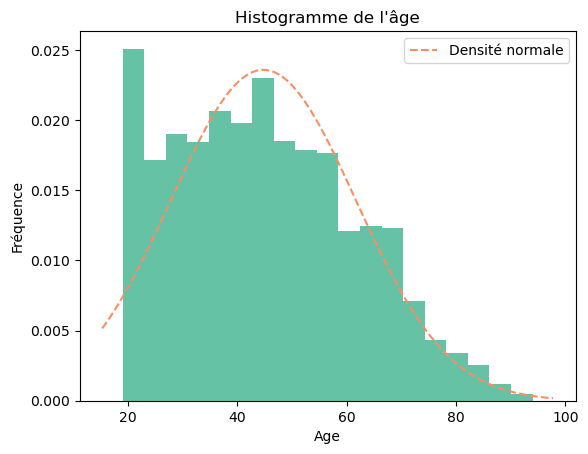

In [66]:
#Visualiser les données sur l'age des clients

plt.hist(age_dépenses['age'], bins=19, density=True)
plt.xlabel("Age")
plt.ylabel("Fréquence")
plt.title("Histogramme de l'âge")

mu, std = norm.fit(age_dépenses['age'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--', label='Densité normale')
plt.legend()
plt.show()



In [67]:
print("Test de Kolmogorov-Smirnov pour normality - age")
ks_2samp(age_dépenses['age'],list(np.random.normal(np.mean(age_dépenses['age']), np.std(age_dépenses['age']), 8600)))

Test de Kolmogorov-Smirnov pour normality - age


KstestResult(statistic=0.06965116279069768, pvalue=1.4729463555952239e-18, statistic_location=18.994470955203838, statistic_sign=-1)

H1 = Les ages des clients ne suivent pas une distribution normale.

Pour le montant total
- H0 = Les montants totals des clients suivent une distribution normale
- H1 = Les montants totals des clients ne suivent pas une distribution normale

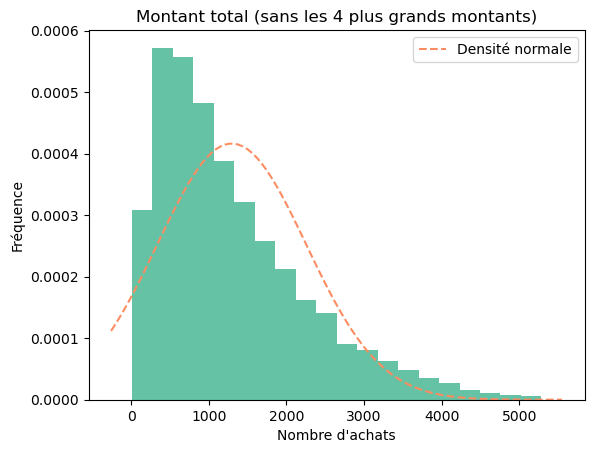

In [68]:
#Suppression du graphique des 4 plus grands nombres d'achats (clients professionnels probables) afin de mieux montrer la répartition
filter = age_dépenses.loc[age_dépenses['dépenses_total'] <= 100000]

plt.hist(filter['dépenses_total'], density=True, bins=20)
plt.xlabel("Nombre d'achats")
plt.ylabel("Fréquence")
plt.title("Montant total (sans les 4 plus grands montants)")

mu, std = norm.fit(filter['dépenses_total'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--', label='Densité normale')
plt.legend()
plt.show()

In [69]:
print("Test de Kolmogorov-Smirnov pour normality - montant total")
ks_2samp(age_dépenses['dépenses_total'],list(np.random.normal(np.mean(age_dépenses['dépenses_total']), np.std(age_dépenses['dépenses_total']), 1000)))

Test de Kolmogorov-Smirnov pour normality - montant total


KstestResult(statistic=0.3844186046511628, pvalue=3.3998380850413815e-119, statistic_location=14.946704297349015, statistic_sign=-1)

H1 = Les montants totals des clients ne suivent pas une distribution normale

Les deux variables ne sont pas normalement distribuées. Je vais utiliser le Spearman Correlation.

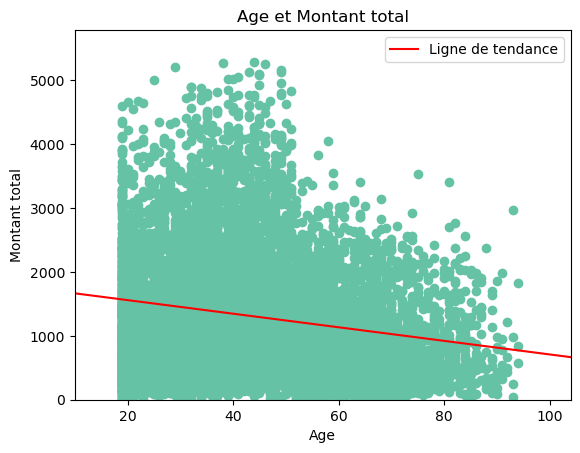

In [70]:
# Graphique d'age et dépenses
plt.scatter(filter['age'], filter['dépenses_total'])
plt.xlabel("Age")
plt.ylabel("Montant total")
plt.title("Age et Montant total")

#Ajouter ligne de tendance
slope, intercept = np.polyfit(filter['age'], filter['dépenses_total'], 1)
trend_line = slope * x + intercept
plt.xlim(min(filter['age']-9), (max(filter['age']+10)))
plt.ylim(0, max(filter['dépenses_total']+500)) 
plt.plot(x, trend_line, color='red', label='Ligne de tendance')


plt.legend()
plt.show()

In [71]:
# Correlation de Spearman
spearman_corr, p_value = stats.spearmanr(age_dépenses['age'], age_dépenses['dépenses_total'])
print("Spearman Correlation:", spearman_corr)
print("P-value =", p_value)

Spearman Correlation: -0.18437931323303366
P-value = 1.237400434992094e-66


Un lien faible et négatif, avec un valeur p aussi faible. Cela suggère H1 - il y a un lien entre l'age d'un client et le montant total d'achats.

#### Age et fréquence d'achats

- Hypothèse nulle (H0) = L'age d'un client et le fréquence des achats ne sont pas liés
- Hypothèse alternative (H1) = L'age d'un client et le fréquence des achats sont liés


In [72]:
#Créer dataframe
age_fréquence = tous_dfs.groupby(['age', 'client_id'])['session_id'].nunique().reset_index().rename(columns={'session_id':'fréquence_dachats'})

Fréquence d'achat
- H0 = Le fréquence d'achats suit une distribution normale
- H1 = Le fréquence d'achats ne suit pas une distribution normale

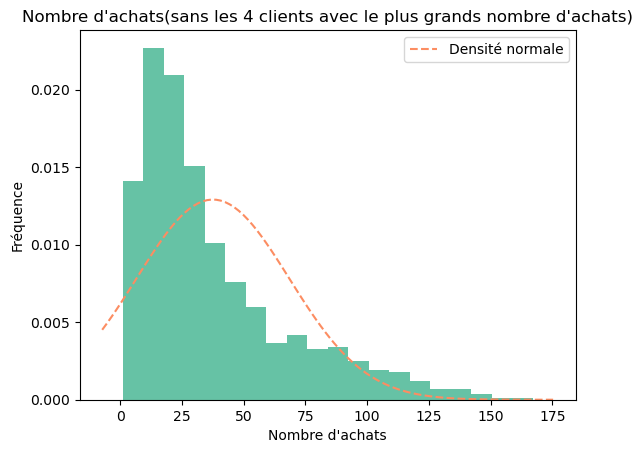

In [73]:
#Removed 4 largest number of purchases (likely professional clients) in order to better show the distribution
filter = age_fréquence.loc[age_fréquence['fréquence_dachats'] <= 2000]

plt.hist(filter['fréquence_dachats'], bins=20, density=True)
plt.xlabel("Nombre d'achats")
plt.ylabel("Fréquence")
plt.title("Nombre d'achats(sans les 4 clients avec le plus grands nombre d'achats)")

mu, std = norm.fit(filter['fréquence_dachats'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--', label='Densité normale')
plt.legend()
plt.show()

In [74]:
print("Test de Kolmogorov-Smirnov pour normality - fréquence d'achats")
ks_2samp(age_fréquence['fréquence_dachats'],list(np.random.normal(np.mean(age_fréquence['fréquence_dachats']), np.std(age_fréquence['fréquence_dachats']), 1000)))

Test de Kolmogorov-Smirnov pour normality - fréquence d'achats


KstestResult(statistic=0.41267441860465115, pvalue=5.353628316308156e-138, statistic_location=1.568558502087484, statistic_sign=-1)

H1 = Le fréquence d'achats ne suit pas une distribution normale

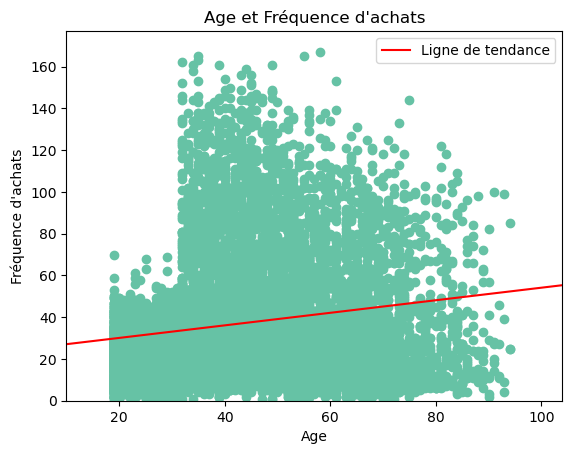

In [75]:
# Graphique d'age et dépenses
plt.scatter(filter['age'], filter['fréquence_dachats'])
plt.xlabel("Age")
plt.ylabel("Fréquence d'achats")
plt.title("Age et Fréquence d'achats")

#Ajouter ligne de tendance
slope, intercept = np.polyfit(filter['age'], filter['fréquence_dachats'], 1)
trend_line = slope * x + intercept
plt.xlim(min(filter['age']-9), (max(filter['age']+10)))
plt.ylim(0, max(filter['fréquence_dachats']+10)) 
plt.plot(x, trend_line, color='red', label='Ligne de tendance')


plt.legend()
plt.show()

In [76]:
# Correlation de Spearman
spearman_corr, p_value = stats.spearmanr(age_fréquence['age'], age_fréquence['fréquence_dachats'])
print("Spearman Correlation:", spearman_corr)
print("P-value =", p_value)

Spearman Correlation: 0.21176722196238146
P-value = 8.802387924159931e-88


Un lien positif, avec un valeur p faible. Cela suggère H1 - il y a un lien entre l'age d'un client et le fréquence d'achats. 

#### Age et taille du panier moyen

- Hypothèse nulle (H0) = L'age d'un client et le taille du panier moyen ne sont pas liés
- Hypothèse (H1) = L'age d'un client et le taille du panier moyen sont liés

In [77]:
#Créer dataframe avec l'age et taille du panier
age_panier = tous_dfs.groupby(['age', 'session_id'])['price'].sum().reset_index().rename(columns={'price':'panier_total'})

Taille du panier moyen
- H0 = Le taille du panier moyen suit une distribution normale
- H1 = Le taille du panier moyen ne suit pas une distribution normale

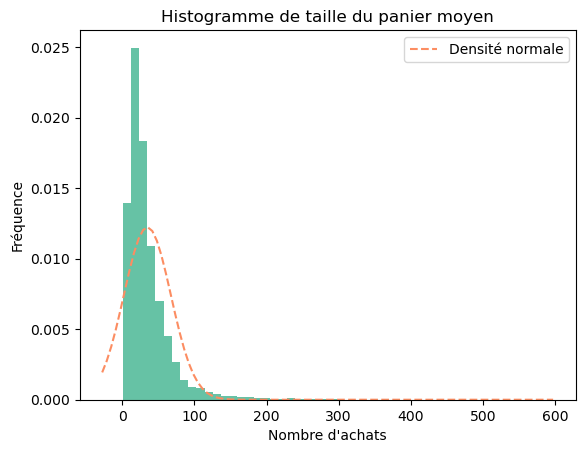

In [78]:
plt.hist(age_panier['panier_total'], bins=50, density=True)
plt.xlabel("Nombre d'achats")
plt.ylabel("Fréquence")
plt.title("Histogramme de taille du panier moyen")

mu, std = norm.fit(age_panier['panier_total'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--', label='Densité normale')
plt.legend()
plt.show()

In [79]:
print("Test de Kolmogorov-Smirnov pour normality - taille du panier moyen")
ks_2samp(age_panier['panier_total'],list(np.random.normal(np.mean(age_panier['panier_total']), np.std(age_panier['panier_total']), 1000)))

Test de Kolmogorov-Smirnov pour normality - taille du panier moyen


KstestResult(statistic=0.1718263700959465, pvalue=3.30085098344454e-26, statistic_location=3.2054761858334864, statistic_sign=-1)

Le taille du panier moyen ne suit pas une distribution normale

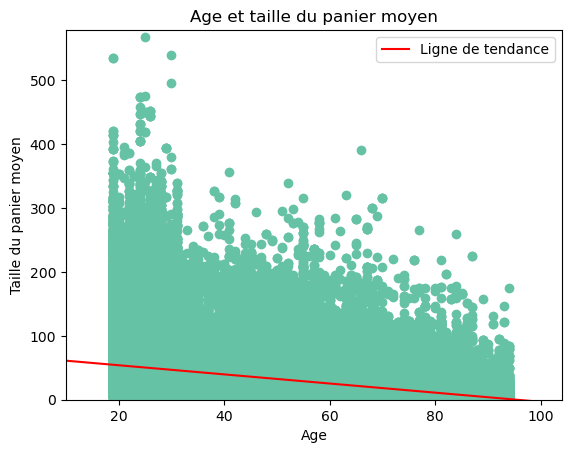

In [80]:
# Graphique d'age et dépenses
plt.scatter(age_panier['age'], age_panier['panier_total'])
plt.xlabel("Age")
plt.ylabel("Taille du panier moyen")
plt.title("Age et taille du panier moyen")

#Ajouter ligne de tendance
slope, intercept = np.polyfit(age_panier['age'], age_panier['panier_total'], 1)
trend_line = slope * x + intercept
plt.xlim(min(age_panier['age']-9), (max(age_panier['age']+10)))
plt.ylim(0, max(age_panier['panier_total']+10)) 
plt.plot(x, trend_line, color='red', label='Ligne de tendance')

plt.legend()
plt.show()

In [81]:
# Correlation de Spearman
spearman_corr, p_value = stats.spearmanr(age_panier['age'], age_panier['panier_total'])
print("Spearman Correlation:", spearman_corr)
print("P-value =", p_value)

Spearman Correlation: -0.3352910080755349
P-value = 0.0


Hypothèse (H1) = L'age d'un client et le taille du panier moyen sont liés

#### L'âge des clients et les catégories des livres achetés

- Hypothèse nulle (H0) = L'age d'un client et le catégorie des livres achetés ne sont pas liés
- Hypothèse (H1) = L'age d'un client et le catégorie des livres achetés sont liés

In [82]:
#Créer une nouvelle dataframe
age_categ_bar = tous_dfs.groupby(['age', 'categ'])['id_prod'].count().reset_index()

age_categ = tous_dfs[['categ', 'age']]
categ_0 = age_categ[age_categ['categ'] == 0]['age']
categ_1 = age_categ[age_categ['categ'] == 1]['age']
categ_2 = age_categ[age_categ['categ'] == 2]['age']

# Create separate data groups for each book category
categs_livres = {}
for catégorie in age_categ['categ'].unique():
    categs_livres[catégorie] = age_categ[age_categ['categ'] == catégorie]['age']

In [83]:
#Créer le tableau de contigence
contingency_table = pd.crosstab(age_categ['age'], age_categ['categ'])
contingency_table

categ,0,1,2
age,,,
19,3418,6067,6012
20,909,1798,1784
21,1016,1850,1845
22,974,1676,1728
23,1114,1744,1671
...,...,...,...
90,142,193,1
91,132,178,2
92,77,91,2


Catégorie de livres achetés
- H0 = Les catégories de livres achetés ont des variances égales
- H1 = Les catégories de livres achetés n'ont pas des variances égales

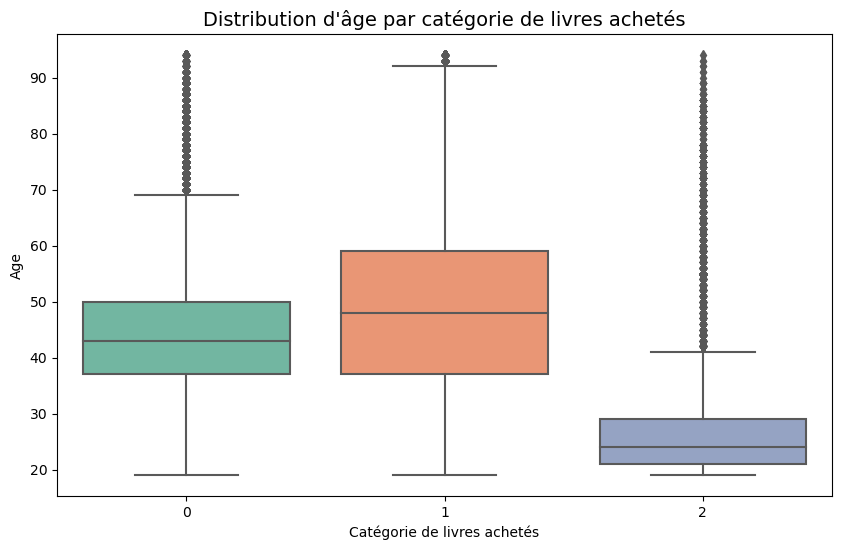

In [84]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=age_categ, x='categ', y='age')
plt.title("Distribution d'âge par catégorie de livres achetés", size=14)
plt.xlabel('Catégorie de livres achetés', size=10)
plt.ylabel('Age', size=10)
plt.xticks()
plt.show()

In [85]:
# Perform Levene's test for equality of variances
levene_test_result = stats.levene(categ_0, categ_1, categ_2)

print("Levene's Test for Equality of Variances:")
print("Statistic:", levene_test_result.statistic)
print("p-value:", levene_test_result.pvalue)

Levene's Test for Equality of Variances:
Statistic: 26975.654952050325
p-value: 0.0


Les variances des données ne sont pas égales. En vue de ça, et que les âges ne sont pas normalement distribués, je vais utiliser un test non paramétrique - Kruskal-Wallis

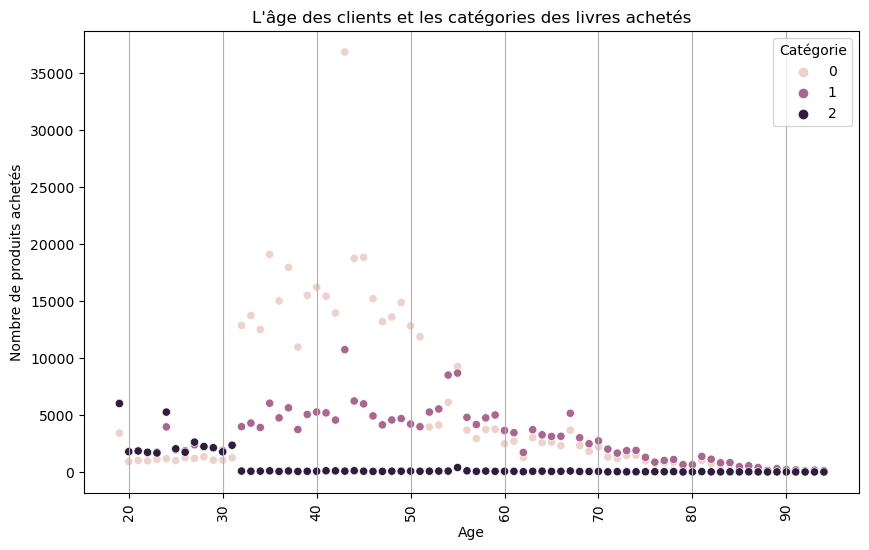

In [86]:
# Créer une nuage de points
plt.figure(figsize=(10, 6))
sns.scatterplot(data=age_categ_bar, x='age', y='id_prod', hue='categ')
plt.xticks(rotation=90)
plt.title("L'âge des clients et les catégories des livres achetés")
plt.xlabel("Age")
plt.ylabel("Nombre de produits achetés")
plt.grid(axis='x')
plt.legend(title='Catégorie')

plt.show()

In [87]:
#Kruskall-Wallis
statistic, p_value = stats.kruskal(categ_0, categ_1, categ_2) 
print("Kruskal-Wallis Test")
print("Statistic =", statistic, "p-value =", p_value)

Kruskal-Wallis Test
Statistic = 78458.43837285662 p-value = 0.0


Hypothèse (H1) = L'age d'un client et le catégorie des livres achetés sont liés